# Transport in 1D

$$
\renewcommand{\DdQq}[2]{{\mathrm D}_{#1}{\mathrm Q}_{#2}}
\renewcommand{\drondt}{\partial_t}
\renewcommand{\drondx}{\partial_x}
\renewcommand{\dx}{\Delta x}
\renewcommand{\dt}{\Delta t}
\renewcommand{\grandO}{{\mathcal O}}
\renewcommand{\density}[2]{\,f_{#1}^{#2}}
\renewcommand{\fk}[1]{\density{#1}{\vphantom{\star}}}
\renewcommand{\fks}[1]{\density{#1}{\star}}
\renewcommand{\moment}[2]{\,m_{#1}^{#2}}
\renewcommand{\mk}[1]{\moment{#1}{\vphantom{\star}}}
\renewcommand{\mke}[1]{\moment{#1}{e}}
\renewcommand{\mks}[1]{\moment{#1}{\star}}
$$

In this tutorial, we test the most simple lattice Boltzmann scheme $\DdQq{1}{2}$ on two classical hyperbolic scalar equations: the advection equation and the Burger's equation.

In [1]:
import sympy as sp
import numpy as np
import pyLBM

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm

%matplotlib notebook
%config InlineBackend.figure_format = 'svg'

## The advection equation

The problem reads
$$\drondt u + c\drondx u = 0, \quad t>0, \quad x\in(0, 1),$$

where $c$ is a constant scalar (typically $c=1$).
Additional boundary and initial conditions will be given in the following.

First, we define the parameters of the problem :

In [2]:
# parameters
xmin, xmax = 0., 1. # bounds of the domain
c = 0.6             # velocity of the transport
uL, uR = 0.5, -0.5  # left and right values of the Riemann problem
Tf = 1.             # final time

def Solution(t, x):
    xm = 0.75*xmin+.25*xmax + c*t
    return uL*(x<xm) + uR*(x>xm) + 0.5*(uL+uR)*(x==xm)

We then plot the exact solution :

<IPython.core.display.Javascript object>


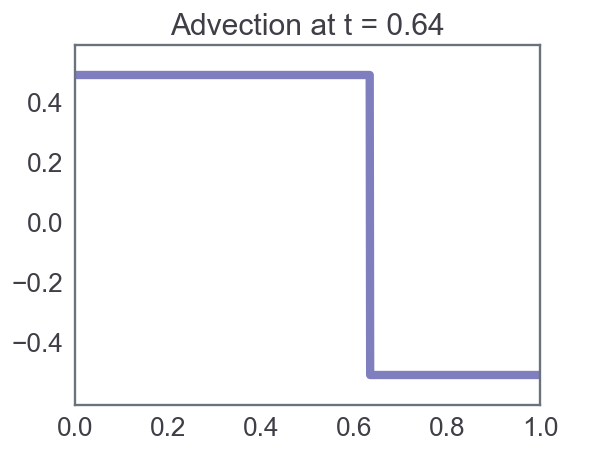

In [3]:
xx = np.linspace(xmin, xmax, 1025)
t = 0
dt = 1./128

ymin, ymax = min(uL, uR), max(uL, uR)
padding = 0.1*(ymax-ymin)

fig, ax = plt.subplots(figsize=(4,3), dpi=150)
ax.grid(False)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin-padding, ymax+padding)
ax.set_title('Advection at t = {0:4.2f}'.format(t))
line = ax.plot(xx, Solution(t, xx), linewidth = 4, color = 'navy', alpha = .5)[0]

def animate(i):
    t = i*dt
    if t<=Tf:
        line.set_data(xx, Solution(t, xx))
        ax.set_title('Advection at t = {0:4.2f}'.format(t))
    
anim = animation.FuncAnimation(fig, animate, frames=500, interval=10)

To simulate this equation, we use the $\DdQq{1}{2}$ scheme given by

* two velocities $v_0=-1$, $v_1=1$, with associated distribution functions $\fk{0}$ and $\fk{1}$,
* a space step $\dx$ and a time step $\dt$, the ration $\lambda=\dx/\dt$ is called the scheme velocity,
* two moments $\mk{0}=\sum_{i=0}^1\fk{i}$ and $\mk{1}=\lambda \sum_{i=0}^1 v_i\fk{i}$ and their equilibrium values $\mke{0} = \mk{0}$, $\mke{1} = c\mk{0}$,
* a relaxation parameter $s$ lying in $[0,2]$.

In order to prepare the formalism of the package pyLBM, we introduce the two polynomials that define the moments: $P_0 = 1$ and $P_1=\lambda X$, such that
$$ 
\mk{k} = \sum_{i=0}^1 P_k(v_i) \fk{i}.
$$

The transformation $(\fk{0}, \fk{1})\mapsto(\mk{0},\mk{1})$ is invertible if, and only if, the polynomials $(P_0,P_1)$ is a free set over the stencil of velocities.

The lattice Boltzmann method consists to compute the distribution functions $\fk{0}$ and $\fk{1}$ in each point of the lattice $x$ and at each time $t^n=n\dt$.
A step of the scheme can be read as a splitting between the relaxation phase and the transport phase:

* relaxation: $$\mks{1}(t,x)=(1-s)\mk{1}(t,x)+s\mke{1}(t,x).$$
* m2f: 
$$\begin{aligned}\fks{0}(t,x)&\;=(\mk{0}(t,x)-\mks{1}(t,x)/\lambda)/2, \\ \fks{1}(t,x)&\;=(\mk{0}(t,x)+\mks{1}(t,x)/\lambda)/2.\end{aligned}
$$
* transport: $$\fk{0}(t+\dt, x)=\fks{0}(t,x+\dx), \qquad \fk{1}(t+\dt, x)=\fks{1}(t,x-\dx).$$
* f2m: 
$$\begin{aligned}\mk{0}(t+\dt,x)&\;=\fk{0}(t+\dt,x)+\fk{1}(t+\dt,x), \\ \mk{1}(t+\dt,x)&\;=-\lambda\fk{0}(t+\dt,x)+\lambda\fk{1}(t+\dt,x).\end{aligned}
$$

The moment of order $0$, $\mk{0}$, being the only one conserved during the relaxation phase, the equivalent equation of this scheme reads at first order

$$\drondt\mk{0} + \drondx\mke{1} = \grandO(\dt).$$

We implement this scheme using `pyLBM`. The dictionary reads :

In [3]:
# dictionary of the simulation
dx = 1./128
la = 1.
s = 1.75
U, X, LA, C, S = sp.symbols('U, X, LA, C, S')

dico = {
    'box': {'x': [xmin, xmax], 'label':0},
    'space_step': dx,
    'scheme_velocity': LA,
    'schemes':[
        {
            'velocities': [1,2],
            'conserved_moments': U,
            'polynomials': [1, X],
            'relaxation_parameters': [0, S],
            'equilibrium': [U, C*U],
            'init': { U: (lambda x: Solution(0., x),)},
        },
    ],
    'boundary_conditions':{
        0: {'method': {0: pyLBM.bc.Neumann}, 'value':None},
    },
    'parameters':{
        LA: la, 
        C: c,
        S: s,
    },
    'generator': 'numpy',
    'show_code': True,
}

It is possible to visualize the geometry of the problem :

Geometry informations
	 spatial dimension: 1
	 bounds of the box: 
[[ 0.  1.]]



<IPython.core.display.Javascript object>


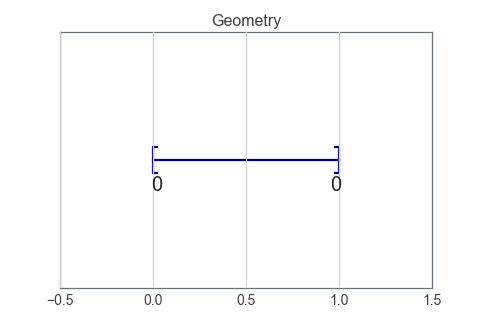

In [5]:
geom = pyLBM.Geometry(dico)
print(geom)
geom.visualize(viewlabel=True, viewgrid=True, fluid_color='navy')

and the domain of the simulation (you can try with a larger space step to have a better experience...)

Domain informations
	 spatial dimension: 1
	 space step: dx= 7.812e-03



<IPython.core.display.Javascript object>


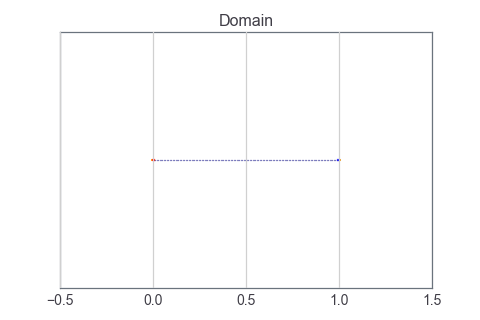

In [6]:
dom = pyLBM.Domain(dico)
print(dom)
dom.visualize(view_distance = True, view_bound = True)

The scheme is created and can be printed :

In [7]:
schema = pyLBM.Scheme(dico)
print(schema)

Scheme informations
	 spatial dimension: dim=1
	 number of schemes: nscheme=1
	 number of velocities:
    Stencil.nv[0]=2
	 velocities value:
    v[0] = (1: 1), (2: -1), 
	 polynomials:
    P[0] = 1, X, 
	 equilibria:
    EQ[0] = U, C*U, 
	 relaxation parameters:
    s[0] = 0, S, 
	 moments matrices
M      = Matrix([[1, 1], [LA, -LA]])
M^(-1) = Matrix([[1/2, 1/(2*LA)], [1/2, -1/(2*LA)]])



Finally, the simulation is built. The code is created, compiled and viewed with the option `show_code`. The simulation is then ready to go.

In [4]:
sol = pyLBM.Simulation(dico)

import numpy as np


def f2m(f, nx, m):
    m[0, 0:nx] = f[0, 0:nx] + f[1, 0:nx]
    m[1, 0:nx] = 1.0*f[0, 0:nx] - 1.0*f[1, 0:nx]
#end
def m2f(m, nx, f):
    f[0, 0:nx] = (0.5)*m[0, 0:nx] + 0.5*m[1, 0:nx]
    f[1, 0:nx] = (0.5)*m[0, 0:nx] - 0.5*m[1, 0:nx]
#end
def equilibrium(nx, m):

    m[1, 0:nx] = 0.6*m[0, 0:nx]
#end
def one_time_step(f, nx, f_new, m):
    m[0, 1:nx - 1] = f[0, 0:nx - 2] + f[1, 2:nx]
    m[1, 1:nx - 1] = 1.0*f[0, 0:nx - 2] - 1.0*f[1, 2:nx]

    m[1, 1:nx - 1] = 1.05*m[0, 1:nx - 1] - 0.75*m[1, 1:nx - 1]
    f_new[0, 1:nx - 1] = (0.5)*m[0, 1:nx - 1] + 0.5*m[1, 1:nx - 1]
    f_new[1, 1:nx - 1] = (0.5)*m[0, 1:nx - 1] - 0.5*m[1, 1:nx - 1]
#end
def neumann(iload0, istore, ncond, nx, f):
    f[istore[0:ncond, 0], istore[0:ncond, 1]] = f[iload0[0:ncond, 0], iload0[0:ncond, 1]]
#end



Even if a internal viewer is proposed, it is possible to run the simulation and visualize the numerical solution in an animation :

<IPython.core.display.Javascript object>


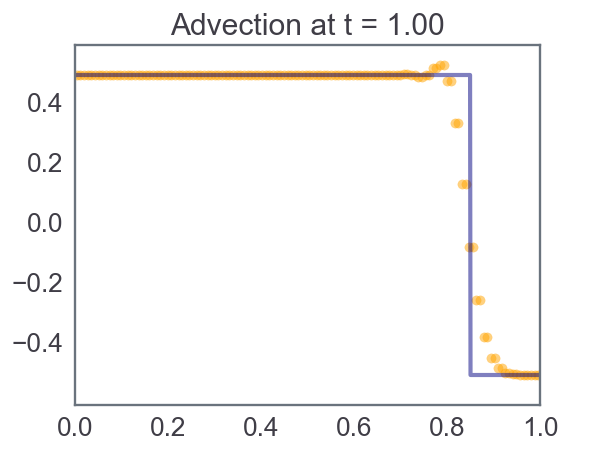

In [7]:
xx = np.linspace(xmin, xmax, 1025)

ymin, ymax = min(uL, uR), max(uL, uR)
padding = 0.1*(ymax-ymin)

fig, ax = plt.subplots(figsize=(4,3), dpi=150)
ax.grid(False)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin-padding, ymax+padding)
ax.set_title('Advection at t = {0:4.2f}'.format(sol.t))
line_e = ax.plot(xx, Solution(sol.t, xx), linewidth = 2, color = 'navy', alpha = .5)[0]
line_a = ax.scatter(sol.domain.x, sol.m[U], marker = 'o', s = 20, color = 'orange', alpha = .5)

def animate(i):
    if sol.t<Tf:
        sol.one_time_step()
        line_e.set_data(xx, Solution(sol.t, xx))
        line_a.set_offsets(np.c_[sol.domain.x, sol.m[U]])
        ax.set_title('Advection at t = {0:4.2f}'.format(sol.t))
    
anim = animation.FuncAnimation(fig, animate, frames=500, interval=1)

Let's try with another scheme. The $D_1Q_3$ is more flexible and rich but the stability condition is more complicated...

In [3]:
# dictionary of the simulation
dx = 1./128
la = 1.
sa, sb = 1.75, 1.75
U, X, LA, C, Sa, Sb = sp.symbols('U, X, LA, C, Sa, Sb')

dico = {
    'box': {'x': [xmin, xmax], 'label':0},
    'space_step': dx,
    'scheme_velocity': LA,
    'schemes':[
        {
            'velocities': [0, 1, 2],
            'conserved_moments': U,
            'polynomials': [1, X, X**2/2],
            'relaxation_parameters': [0, Sa, Sb],
            'equilibrium': [U, C*U, C**2*U],
            'init': { U: (lambda x: Solution(0., x),)},
        },
    ],
    'boundary_conditions':{
        0: {'method': {0: pyLBM.bc.Neumann}, 'value':None},
    },
    'parameters':{
        LA: la, 
        C: c,
        Sa: sa,
        Sb: sb
    },
    'generator': 'numpy',
    'show_code': True,
}

sol = pyLBM.Simulation(dico)

import numpy as np


def f2m(f, nx, m):
    m[0, 0:nx] = f[0, 0:nx] + f[1, 0:nx] + f[2, 0:nx]
    m[1, 0:nx] = 1.0*f[1, 0:nx] - 1.0*f[2, 0:nx]
    m[2, 0:nx] = 0.5*f[1, 0:nx] + 0.5*f[2, 0:nx]
#end
def m2f(m, nx, f):
    f[0, 0:nx] = m[0, 0:nx] - 2.0*m[2, 0:nx]
    f[1, 0:nx] = 0.5*m[1, 0:nx] + 1.0*m[2, 0:nx]
    f[2, 0:nx] = -0.5*m[1, 0:nx] + 1.0*m[2, 0:nx]
#end
def equilibrium(nx, m):

    m[1, 0:nx] = 0.6*m[0, 0:nx]
    m[2, 0:nx] = 0.36*m[0, 0:nx]
#end
def one_time_step(f, nx, f_new, m):
    m[0, 1:nx - 1] = f[0, 1:nx - 1] + f[1, 0:nx - 2] + f[2, 2:nx]
    m[1, 1:nx - 1] = 1.0*f[1, 0:nx - 2] - 1.0*f[2, 2:nx]
    m[2, 1:nx - 1] = 0.5*f[1, 0:nx - 2] + 0.5*f[2, 2:nx]

    m[1, 1:nx - 1] = 1.05*m[0, 1:nx - 1] - 0.75*m[1, 1:nx - 1]
    m[2, 1:nx - 1] = 0.63*m[0, 1:nx - 1] - 0.75*m[2, 1:nx - 1]
    f_new[0, 1:nx - 1] = m[0, 1:nx - 1] - 2.0*m[2, 1:nx - 1]
    f_new[1, 1:nx - 1] = 0.5*m[1, 1:nx - 1] + 1.0*m[2, 1:nx - 1]
    f_new[2, 1:nx - 1] = -0.5*m[1, 1:nx - 1] + 1.0*m[2, 1:nx - 1]
#end


<IPython.core.display.Javascript object>


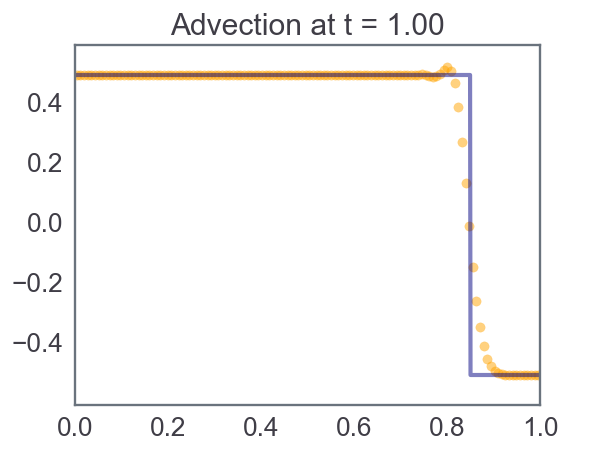

In [8]:
xx = np.linspace(xmin, xmax, 1025)

ymin, ymax = min(uL, uR), max(uL, uR)
padding = 0.1*(ymax-ymin)

fig, ax = plt.subplots(figsize=(4,3), dpi=150)
ax.grid(False)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin-padding, ymax+padding)
ax.set_title('Advection at t = {0:4.2f}'.format(sol.t))
line_e = ax.plot(xx, Solution(sol.t, xx), linewidth = 2, color = 'navy', alpha = .5)[0]
line_a = ax.scatter(sol.domain.x, sol.m[U], marker = 'o', s = 20, color = 'orange', alpha = .5)

def animate(i):
    if sol.t<Tf:
        sol.one_time_step()
        line_e.set_data(xx, Solution(sol.t, xx))
        line_a.set_offsets(np.c_[sol.domain.x, sol.m[U]])
        ax.set_title('Advection at t = {0:4.2f}'.format(sol.t))
    
anim = animation.FuncAnimation(fig, animate, frames=500, interval=1)

## The Burger's equation

The problem reads
$$\drondt u + \tfrac{1}{2} \drondx u^2 = 0, \quad t>0, \quad x\in(0, 1).$$

The previous $\DdQq{1}{2}$ scheme can simulate the Burger's equation by modifying the equilibrium value of the moment of order $1$ $\mke{1}$. 
It now reads $\mke{1} = {\mk{0}}^2/2$.

More generaly, the simulated equation is into the conservative form
$$\drondt u + \drondx \varphi(u) = 0, \quad t>0, \quad x\in(0, 1),$$

the equilibrium has to be taken to $\mke{1}=\varphi(\mk{0})$.

We just have to modify the equilibrium and the initialization of the previous example to simulate the Burger's equation. The initial condition can be a discontinuous function in order to simulate Riemann problems. Note that the function f2m, m2f, relaxation, and transport are unchanged.

In [1]:
import sympy as sp
import numpy as np
import pyLBM

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm

%matplotlib notebook
%config InlineBackend.figure_format = 'retina'

In [10]:
# parameters
xmin, xmax = 0., 1. # bounds of the domain
uL, uR = .5, .0     # left and right values of the Riemann problem
Tf = 1.             # final time

def Solution(t, x):
    xm = 0.5*xmin+0.5*xmax
    y = np.zeros(x.shape)
    if uL>=uR:
        # shock
        sigma = .5*(uL+uR)
        xm += sigma*t
        y[x<xm] = uL
        y[x==xm] = .5 * (uL + uR)
        y[x>xm] = uR
    else:
        # rarefaction
        xL = xm + uL*t
        xR = xm + uR*t
        if xR != xL:
            y[:] = ( (x-xL) * uR - (x-xR) * uL ) / (xR-xL)
        y[x<=xL] = uL
        y[x>=xR] = uR
    return y

In [11]:
dx = 1./128
la = 1.
s = 1.75
U, X, LA, S = sp.symbols('U, X, LA, S')

dicoD1Q2 = {
    'box': {'x': [xmin, xmax], 'label':0},
    'space_step': dx,
    'scheme_velocity': LA,
    'schemes':[
        {
            'velocities': [1,2],
            'conserved_moments': U,
            'polynomials': [1, X],
            'relaxation_parameters': [0, S],
            'equilibrium': [U, U**2/2],
            'init': { U: (lambda x: Solution(0., x),)},
        },
    ],
    'boundary_conditions':{
        0: {'method': {0: pyLBM.bc.Neumann}, 'value':None},
    },
    'parameters':{
        LA: la, 
        S: s,
    },
    'generator': 'numpy',
    'show_code': False,
}

sol = pyLBM.Simulation(dicoD1Q2)

<IPython.core.display.Javascript object>


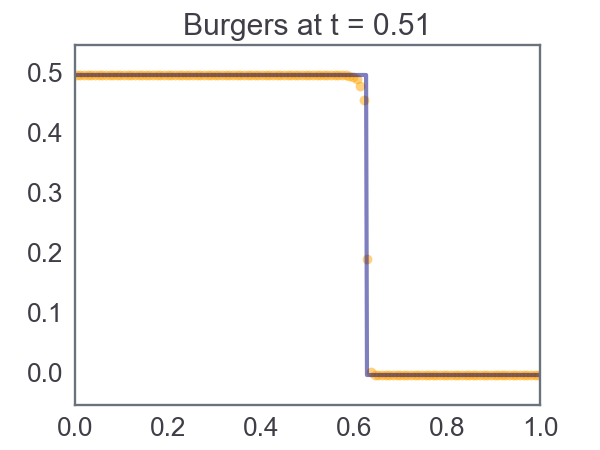

In [12]:
xx = np.linspace(xmin, xmax, 1025)

ymin, ymax = min(uL, uR), max(uL, uR)
padding = 0.1*(ymax-ymin)

fig, ax = plt.subplots(figsize=(4,3), dpi=150)
ax.grid(False)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin-padding, ymax+padding)
ax.set_title('Burgers at t = {0:4.2f}'.format(sol.t))
line_e = ax.plot(xx, Solution(sol.t, xx), linewidth = 2, color = 'navy', alpha = .5)[0]
line_a = ax.scatter(sol.domain.x, sol.m[U], marker = 'o', s = 20, color = 'orange', alpha = .5)

def animate(i):
    if sol.t<Tf:
        sol.one_time_step()
        line_e.set_data(xx, Solution(sol.t, xx))
        line_a.set_offsets(np.c_[sol.domain.x, sol.m[U]])
        ax.set_title('Burgers at t = {0:4.2f}'.format(sol.t))
    
anim = animation.FuncAnimation(fig, animate, frames=500, interval=1)

In [13]:
dx = 1./128
la = 1.
sa, sb = 1., 1.
U, X, LA, Sa, Sb = sp.symbols('U, X, LA, Sa, Sb')

dicoD1Q3 = {
    'box': {'x': [xmin, xmax], 'label':0},
    'space_step': dx,
    'scheme_velocity': LA,
    'schemes':[
        {
            'velocities': [0, 1,2],
            'conserved_moments': U,
            'polynomials': [1, X, X**2/2],
            'relaxation_parameters': [0, Sa, Sb],
            'equilibrium': [U, U**2/2, 2*U**3/4],
            'init': { U: (lambda x: Solution(0., x),)},
        },
    ],
    'boundary_conditions':{
        0: {'method': {0: pyLBM.bc.Neumann}, 'value':None},
    },
    'parameters':{
        LA: la, 
        Sa: sa,
        Sb: sb
    },
    'generator': 'numpy',
    'show_code': False,
}

sol = pyLBM.Simulation(dicoD1Q3)

<IPython.core.display.Javascript object>


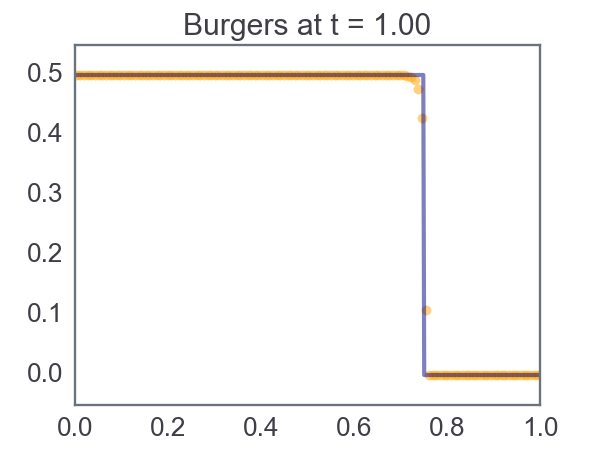

In [14]:
xx = np.linspace(xmin, xmax, 1025)

ymin, ymax = min(uL, uR), max(uL, uR)
padding = 0.1*(ymax-ymin)

fig, ax = plt.subplots(figsize=(4,3), dpi=150)
ax.grid(False)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin-padding, ymax+padding)
ax.set_title('Burgers at t = {0:4.2f}'.format(sol.t))
line_e = ax.plot(xx, Solution(sol.t, xx), linewidth = 2, color = 'navy', alpha = .5)[0]
line_a = ax.scatter(sol.domain.x, sol.m[U], marker = 'o', s = 20, color = 'orange', alpha = .5)

def animate(i):
    if sol.t<Tf:
        sol.one_time_step()
        line_e.set_data(xx, Solution(sol.t, xx))
        line_a.set_offsets(np.c_[sol.domain.x, sol.m[U]])
        ax.set_title('Burgers at t = {0:4.2f}'.format(sol.t))
    
anim = animation.FuncAnimation(fig, animate, frames=500, interval=1)